In [1]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
pip install ninja 2>> install.log
git clone https://github.com/SIDN-IAP/global-model-repr.git tutorial_code 2>> install.log

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 13.1 MB/s eta 0:00:00


In [3]:
try: # set up path
    import google.colab, sys, torch
    sys.path.append('/content/tutorial_code')
    if not torch.cuda.is_available():
        print("Change runtime type to include a GPU.")
except:
    pass


# GAN Dissection

Our mission: look inside a GAN generator to see what it does.

We begin with some imports and jupyter setup.

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

In [5]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Running pytorch', torch.__version__, 'using', device.type)

Running pytorch 2.6.0+cu124 using cuda


## Instantiating a pretrained GAN generator.

We're going to use a progressive GAN.

Below I download and instantiate a model for outdoor churches.

You can uncomment the model of your choice.

After we create the model, I just print out all the layers.

In [6]:
import torchvision
import torch.hub
from netdissect import nethook, proggan

# n = 'proggan_bedroom-d8a89ff1.pth'
n = 'proggan_churchoutdoor-7e701dd5.pth'
# n = 'proggan_conferenceroom-21e85882.pth'
# n = 'proggan_diningroom-3aa0ab80.pth'
# n = 'proggan_kitchen-67f1e16c.pth'
# n = 'proggan_livingroom-5ef336dd.pth'
# n = 'proggan_restaurant-b8578299.pth'

url = 'http://gandissect.csail.mit.edu/models/' + n
try:
    sd = torch.hub.load_state_dict_from_url(url) # pytorch 1.1
except:
    sd = torch.hub.model_zoo.load_url(url) # pytorch 1.0
model = proggan.from_state_dict(sd).to(device)
model

Downloading: "http://gandissect.csail.mit.edu/models/proggan_churchoutdoor-7e701dd5.pth" to /root/.cache/torch/hub/checkpoints/proggan_churchoutdoor-7e701dd5.pth
100%|██████████| 70.0M/70.0M [00:02<00:00, 27.7MB/s]


ProgressiveGenerator(
  (layer1): NormConvBlock(
    (norm): PixelNormLayer()
    (conv): Conv2d(512, 512, kernel_size=(4, 4), stride=(1, 1), padding=(3, 3), bias=False)
    (wscale): WScaleLayer()
    (relu): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer2): NormConvBlock(
    (norm): PixelNormLayer()
    (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (wscale): WScaleLayer()
    (relu): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer3): NormUpscaleConvBlock(
    (norm): PixelNormLayer()
    (up): DoubleResolutionLayer()
    (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (wscale): WScaleLayer()
    (relu): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer4): NormConvBlock(
    (norm): PixelNormLayer()
    (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (wscale): WScaleLayer()
    (relu): LeakyReLU(negative_slope=0.2, inplace=Tru

# Exercise 1 - Directly inspect the internal representation

In this exercise we just run the code provided and scrutinize the activations directly.

## Running the model.

The GAN generator is just a function z->x that transforms random z to realistic images x.

To generate images, all we need is a source of random z.  Let's make a micro dataset with a few random z.

In [7]:
from netdissect import zdataset

SAMPLE_SIZE = 50 # Increase this for better results
zds = zdataset.z_dataset_for_model(model, size=SAMPLE_SIZE, seed=5555)
len(zds), zds[0][0].shape

(50, torch.Size([512, 1, 1]))

We can just invoke model(z[None,...]) to generate a single image.

In [8]:
# Look at the output data - print a few pixel values
model(zds[0][0][None,...].to(device))[0,0,:10]

tensor([[0.8654, 0.9015, 0.8849,  ..., 0.2952, 0.2789, 0.2471],
        [0.9708, 0.9232, 0.9127,  ..., 0.2716, 0.2361, 0.2304],
        [0.9478, 0.9262, 0.9267,  ..., 0.2756, 0.2419, 0.2437],
        ...,
        [0.9530, 0.9417, 0.9386,  ..., 0.3457, 0.3078, 0.3125],
        [0.9532, 0.9449, 0.9411,  ..., 0.3678, 0.3314, 0.3299],
        [0.9540, 0.9449, 0.9419,  ..., 0.3802, 0.3466, 0.3491]],
       device='cuda:0', grad_fn=<SliceBackward0>)

## Visualizing the output.

The netdissect toolkit comes with a few simple visualization tools for examining images in notebooks.

  * renormalize turns tensors that were normalized as [-1...1] back into PIL images.
  * show takes nested arrays of images and text and lays then out as grids and tables.
  
Let's look at the images we created with our model.

In [9]:
from netdissect import renormalize, show
# from IPython.display import display

show([
    [renormalize.as_image(model(z[None,...].to(device))[0])]
    for [z] in zds
])


Output hidden; open in https://colab.research.google.com to view.

## Hooking a model with InstrumentedModel

To analyze what a model is doing inside, we can wrap it with an InstrumentedModel, which makes it easy to hook or modify a particular layer.

InstrumentedModel adds a few useful functions for inspecting a model, including:
   * `model.retain_layer('layername')` - hooks a layer to hold on to its output after computation
   * `model.retained_layer('layername')` - returns the retained data from the last computation
   * `model.edit_layer('layername', rule=...)` - runs the `rule` function after the given layer
   * `model.remove_edits()` - removes editing rules

Let's setup `retain_layer` now.  We'll pick a layer sort of in the early-middle of the generator.  You can pick whatever you like.

In [10]:
# TODO: add a summary of what InstrumentedModel can do.
# retain a layer, get a retined layer, edit a layer

from netdissect import nethook

# Don't re-wrap it, if it's already wrapped (e.g., if you press enter twice)
if not isinstance(model, nethook.InstrumentedModel):
    model = nethook.InstrumentedModel(model)
model.retain_layer('layer4')

Now we can run the model and inspect the internal units.

In [11]:
# Run the model
img = model(zds[0][0][None,...].to(device))

# As a side-effect, the model has retained the output of layer4.
acts = model.retained_layer('layer4')

# We can look at it.  How much data is it?
acts.shape

torch.Size([1, 512, 8, 8])

In [12]:
# Let's just look at the 0th convolutional channel.
print(acts[0,0])


tensor([[-0.3780, -0.2439, -0.1824, -0.1798, -0.0635,  0.5947,  0.0497,  1.3406],
        [-0.4630, -0.1521, -0.1447, -0.7038, -0.5338,  0.7345, -0.0789,  1.0032],
        [-0.4260, -0.3278,  0.1741, -0.7402, -0.5182,  1.2732, -0.0845, -0.0208],
        [-0.2540, -0.2801,  0.7733, -0.4419, -0.2017,  1.6757, -0.0564, -0.0325],
        [-0.6896, -0.6121, -0.0525, -0.8923, -0.6397, -0.3707, -0.7826, -0.3145],
        [-1.1871, -1.1210, -0.2864, -1.0593, -1.3274, -1.1936, -1.3434, -0.6379],
        [-0.8832, -0.9165, -0.4149, -0.3597, -0.9975, -1.2343, -1.3093, -0.5713],
        [-0.5132, -1.1210, -1.1503, -0.7243, -0.9133, -1.1067, -1.3048, -0.6174]],
       device='cuda:0')


## Visualizing activation data

It can be informative to visualize activation data instead of just looking at the numbers.

Net dissection comes with an ImageVisualizer object for visualizing grid data as an image in a few different ways.  Here is a heatmap of the array above:

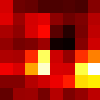

In [13]:
from netdissect import imgviz
iv = imgviz.ImageVisualizer(100)
iv.heatmap(acts[0,1], mode='nearest')

If you tell IV to dereference the activations for you, it scales heatmaps according to global statistics.

What is happening with unit 418?

Each unit has a different scale, which makes the heatmaps harder to interpret.

We can normalize the scales by collecting stats.


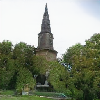
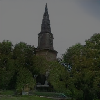
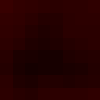
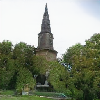
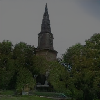
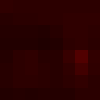
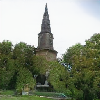
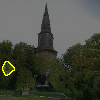
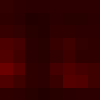
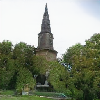
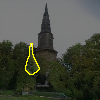
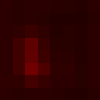
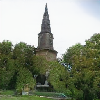
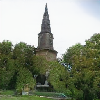
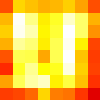
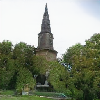
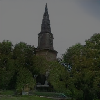
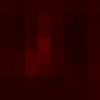

In [14]:
show(
    [['unit %d' % u,
      [iv.image(img[0])],
      [iv.masked_image(img[0], acts, (0,u))],
      [iv.heatmap(acts, (0,u), mode='nearest')],
     ] for u in range(414, 420)]
)

## Collecting quantile statistics for every unit

We want to know per-channel minimum or maximum values, means, medians, quantiles, etc.

We want to treat each pixel as its own sample for all the channels.  For example, here are the activations for one image as an 8x8 tensor over with 512 channels.  We can disregard the geometry and just look at it as a 64x512 sample matrix, that is 64 samples of 512-dimensional vectors.

In [15]:
print(acts.shape)
print(acts.permute(0, 2, 3, 1).contiguous().view(-1, acts.shape[1]).shape)

torch.Size([1, 512, 8, 8])
torch.Size([64, 512])


Net dissection has a tally package that tracks quantiles over large samples.

To use it, just define a function that returns sample matrices like the 64x512 above, and then it will call your function on every batch and tally up the statistics.

In [16]:
from netdissect import tally

# To collect stats, define a function that returns 2d [samples, units]
def compute_samples(zbatch):
    _ = model(zbatch.to(device))          # run the model
    acts = model.retained_layer('layer4') # get the activations, and flatten
    return acts.permute(0, 2, 3, 1).contiguous().view(-1, acts.shape[1])

# Then tally_quantile will run your function over the whole dataset to collect quantile stats
rq = tally.tally_quantile(compute_samples, zds)

# Print out the median value for the first 20 channels
rq.quantiles(0.5)[:20]

tensor([-0.4046, -0.5428, -0.3631,  2.9844, -0.2847, -0.5570, -0.6854, -0.8811,
        -0.3581, -0.7223, -1.1460, -0.5441, -0.8785, -0.5749, -0.9384, -0.8077,
        -0.0543, -0.7799, -0.6179, -0.5356])

In [17]:
torch.tensor(3).dtype

torch.int64

## Exploring quantiles

The rq object tracks a sketch of all the quantiles of the sampled data.  For example, what is the mean, median, and percentile value for each unit?

In [18]:
# This tells me now, for example, what the means are for channel,
# rq.mean()
# what median is,
# rq.quantiles(0.5)
# Or what the 99th percentile quantile is.
# rq.quantiles(0.99)

(rq.quantiles(0.8) > 0).sum()

tensor(294)

The quantiles can be plugged directly into the ImageVisualizer to put heatmaps on an informative per-unit scale.  When you do this:

   * Heatmaps are shown on a scale from black to white from 1% lowest to the 99% highest value.
   * Masked image lassos are shown at a 95% percentile level (by default, can be changed).
   
Now unit 418 doesn't drown out the other ones in the visualization.


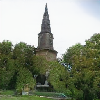
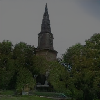
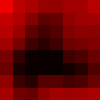
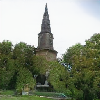
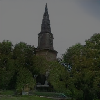
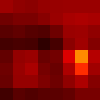
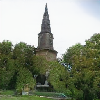
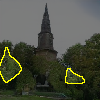
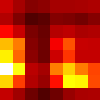
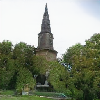
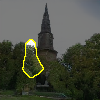
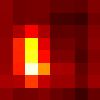
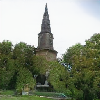
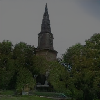
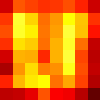
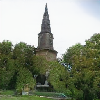
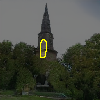
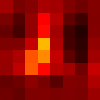

In [19]:
iv = imgviz.ImageVisualizer(100, quantiles=rq)
show([
    [  # for every unit, make a block containing
       'unit %d' % u,         # the unit number
       [iv.image(img[0])],    # the unmodified image
       [iv.masked_image(img[0], acts, (0,u))], # the masked image
       [iv.heatmap(acts, (0,u), mode='nearest')], # the heatmap
    ]
    for u in range(414, 420)
])

## Visualizing top-activating images

A useful way to visualize units is to sort a sample, in order of highest activation.  tally_topk does this.

Like torch.topk, it returns both the top k values and the top k indexes.  But instead of acting on a single tensor, it iterates over the whole data set.

In [20]:
def compute_image_max(zbatch):
    image_batch = model(zbatch.to(device))
    return model.retained_layer('layer4').max(3)[0].max(2)[0]

topk = tally.tally_topk(compute_image_max, zds)
topk.result()[1].shape

torch.Size([512, 50])


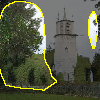
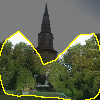
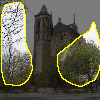
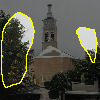
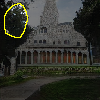
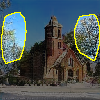
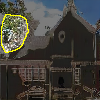
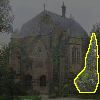

In [21]:
# For each unit, this function prints out unit masks from the top-activating images
def unit_viz_row(unitnum, percent_level=0.95):
    out = []
    for imgnum in topk.result()[1][unitnum][:8]:
        img = model(zds[imgnum][0][None,...].to(device))
        acts = model.retained_layer('layer4')
        out.append([imgnum.item(),
                    # [iv.image(img[0])],
                    [iv.masked_image(img[0], acts, (0, unitnum), percent_level=percent_level)],
                    # [iv.heatmap(acts, (0, unitnum), mode='nearest')],
                   ])
    return out

show(unit_viz_row(365))